# Patent Funding Modeling 

## 0. Import required packages and load dataset 

In [132]:
# general packages
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pprint import pprint
import warnings
#warnings.filterwarnings("ignore")
import pickle

# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix,classification_report
from xgboost import XGBClassifier

# imbelearn package
from imblearn.over_sampling import SMOTE

## 1. Read data

In [37]:
df = pd.read_csv('modeling.csv', sep = ',')

# print first few rows of df 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 41 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Unnamed: 0                                        3166 non-null   int64  
 1   Disclosure_Date                                   3166 non-null   float64
 2   Country_WIPO_ID                                   3166 non-null   float64
 3   Actually_File_Date                                3166 non-null   float64
 4   Is_Priority                                       3166 non-null   float64
 5   Lawfirm                                           3166 non-null   float64
 6   Attorney                                          3166 non-null   float64
 7   Number_of_Inventors                               3166 non-null   float64
 8   Application_Type                                  3166 non-null   float64
 9   Lead_Inventor      

## 2. Model Preprocessing

In [38]:
# drop unamed column 
df = df.drop(df.columns[0], axis=1)

# Remove row with null patent_status
df = df.dropna(subset=['Patent_Status'])

# convert funding status to binary 
df.loc[df['Patent_Status']=='no_fund', 'Patent_Status'] = 0
df.loc[df['Patent_Status']=='fund', 'Patent_Status'] = 1
df["Patent_Status"] = df.Patent_Status.astype(float)

df.head()

,Disclosure_Date,Country_WIPO_ID,Actually_File_Date,Is_Priority,Lawfirm,Attorney,Number_of_Inventors,Application_Type,Lead_Inventor,Division_Department,...,topic1,topic2,topic3,lda_topic,Patents_in_Division,Successful Patents_in_Division,Division_Patent_Success_Rate,Patents_in_Tech,Disclosure_to_Filing,Patent_Status
0,0.372629,0.941860,0.370048,1.0,0.701031,0.659722,0.000000,0.888889,0.331307,0.633333,...,0.042594,0.895720,0.065075,0.5,1.0,1.0,0.379626,0.000000,0.510944,0.0
1,0.571259,0.941860,0.561741,1.0,0.154639,0.881944,0.000000,0.888889,0.145897,0.006667,...,0.018785,0.736053,0.251967,0.5,1.0,1.0,0.379626,0.000000,0.502780,0.0
2,0.782425,0.941860,0.793953,1.0,0.701031,0.812500,0.111111,0.666667,0.872340,0.746667,...,0.034030,0.432757,0.545258,1.0,1.0,1.0,0.379626,0.000000,0.529453,0.0
3,0.617259,0.058140,0.710370,0.0,0.701031,0.812500,0.166667,1.000000,0.589666,0.406667,...,0.884092,0.058615,0.058616,0.0,1.0,1.0,0.379626,0.089888,0.630657,0.0
4,0.617259,0.104651,0.658887,0.0,0.701031,0.812500,0.166667,0.444444,0.589666,0.406667,...,0.884092,0.058615,0.058616,0.0,1.0,1.0,0.379626,0.089888,0.566542,0.0


In [39]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Keeping the highly correlated features attains higher model scoring, so we will keep
to_drop

# # Drop features 
#df.drop(to_drop, axis=1, inplace=True)

<ipython-input-39-69866c654d74>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['Actually_File_Date', 'Successful Patents_in_Division']

In [40]:
X = df.iloc[:, 0:39]
y = df.iloc[:, 39]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# check split of data
len(x_train), len(y_train), len(x_test), len(y_test), len(df)

(2532, 2532, 633, 633, 3165)

In [41]:
# Employment of SMOTE to oversample skewed funding outputs. This yields better results 
sm = SMOTE()
x_train, y_train = sm.fit_resample(x_train, y_train)

# check shape of x_train and y_train, and new response variable ratio
print(x_train.shape)
print(y_train.shape)
print(y_train.value_counts(normalize = True))

(3772, 39)
(3772,)
0.0    0.5
1.0    0.5
Name: Patent_Status, dtype: float64


## 3. Binary Classification Modeling Pipeline


### Ensemble learning models perform better than standard binary classification models

In [141]:
pipelines = []
# Standard binary classification models 
pipelines.append(('LogisticRegression', Pipeline([('LR',linear_model.LogisticRegression())])))
pipelines.append(('KNearestNeighbors', Pipeline([('KNN',KNeighborsClassifier())])))
pipelines.append(('LinearSVC', Pipeline([('SVC',LinearSVC())])))
pipelines.append(('DecisionTree', Pipeline([('DTREE',DecisionTreeClassifier())])))
# Employment of ensemble learning 
pipelines.append(('BaggingClassifier', Pipeline([('BAG',BaggingClassifier())])))
pipelines.append(('BoostClassifier', Pipeline([('BOOST',AdaBoostClassifier())])))
pipelines.append(('RandomForest', Pipeline([('FOREST',RandomForestClassifier())])))
pipelines.append(('GradientBoost', Pipeline([('GBoost',GradientBoostingClassifier())])))
pipelines.append(('XGBoosting', Pipeline([('XGBoost',XGBClassifier(objective='binary:logistic', eval_metric='error'))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression: 0.847249 (0.019579)
KNearestNeighbors: 0.915242 (0.017778)
LinearSVC: 0.847779 (0.020473)
DecisionTree: 0.919766 (0.020707)
BaggingClassifier: 0.941564 (0.016001)
BoostClassifier: 0.904581 (0.019617)
RandomForest: 0.944745 (0.012156)
GradientBoost: 0.932360 (0.014038)


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of 

XGBoosting: 0.954009 (0.009774)


### Models with top recall score:
1. RandomForest
2. BaggingClassifier
3. GradientBoost
4. DecisionTree
5. KNearestNeighbors
6. XGBoost

## 4. Model Outputs for selected models

# Add table displaying error for Train, Test, CV to output results below

In [43]:
def roc_curve(model):
    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [44]:
def fitting_score(train_predictions, test_predictions, model):
    # Evaluate the train, test and CV metrics
    # train
    train_recall = metrics.recall_score(y_train, train_predictions, average='macro')
    train_precision = metrics.precision_score(y_train, train_predictions, average='macro')
    train_f1 = metrics.f1_score(y_train, train_predictions, average='macro')

    # test
    test_recall = metrics.recall_score(y_test, test_predictions, average='macro')
    test_precision = metrics.precision_score(y_test, test_predictions, average='macro')
    test_f1 = metrics.f1_score(y_test, test_predictions, average='macro')

    # CV
    cv_recall = cross_val_score(model, x_train, y_train, cv=5, scoring='recall', n_jobs=-1).mean()
    cv_precision = cross_val_score(model, x_train, y_train, cv=5, scoring='precision', n_jobs=-1).mean()
    cv_f1 = cross_val_score(model, x_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    # Put everything in a table
    d = {'train': [train_recall, train_precision, train_f1], 'test': [test_recall, test_precision, test_f1],
        'cv':[cv_recall, cv_precision, cv_f1]}
    score_df = pd.DataFrame(data=d, index=['recall', 'precision', 'f1'])
    return score_df.round(decimals=3)

### 4.1. Random Forest 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


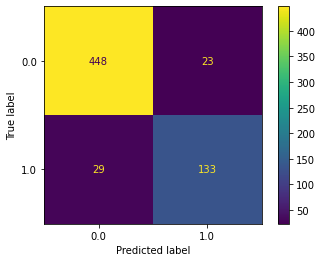


Random Forest Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       471
         1.0       0.85      0.82      0.84       162

    accuracy                           0.92       633
   macro avg       0.90      0.89      0.89       633
weighted avg       0.92      0.92      0.92       633


Accuracy: 0.918

 Random Forest Train/Test/CV Scoring


,train,test,cv
recall,0.999,0.886,0.948
precision,0.999,0.896,0.941
f1,0.999,0.891,0.944


In [92]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(random_state=42)
rfc.fit(x_train, y_train)
rfc_predictions = rfc.predict(x_test)
rfc_predictions_train=rfc.predict(x_train)

rfc_matrix = metrics.confusion_matrix(y_test,rfc_predictions)

plot_confusion_matrix(rfc, x_test, y_test)  
plt.show()

class_report_rfc = classification_report(y_test, rfc_predictions)
print("\nRandom Forest Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,rfc_predictions),3))


print('\n Random Forest Train/Test/CV Scoring')
fitting_score(rfc_predictions_train, rfc_predictions, rfc)

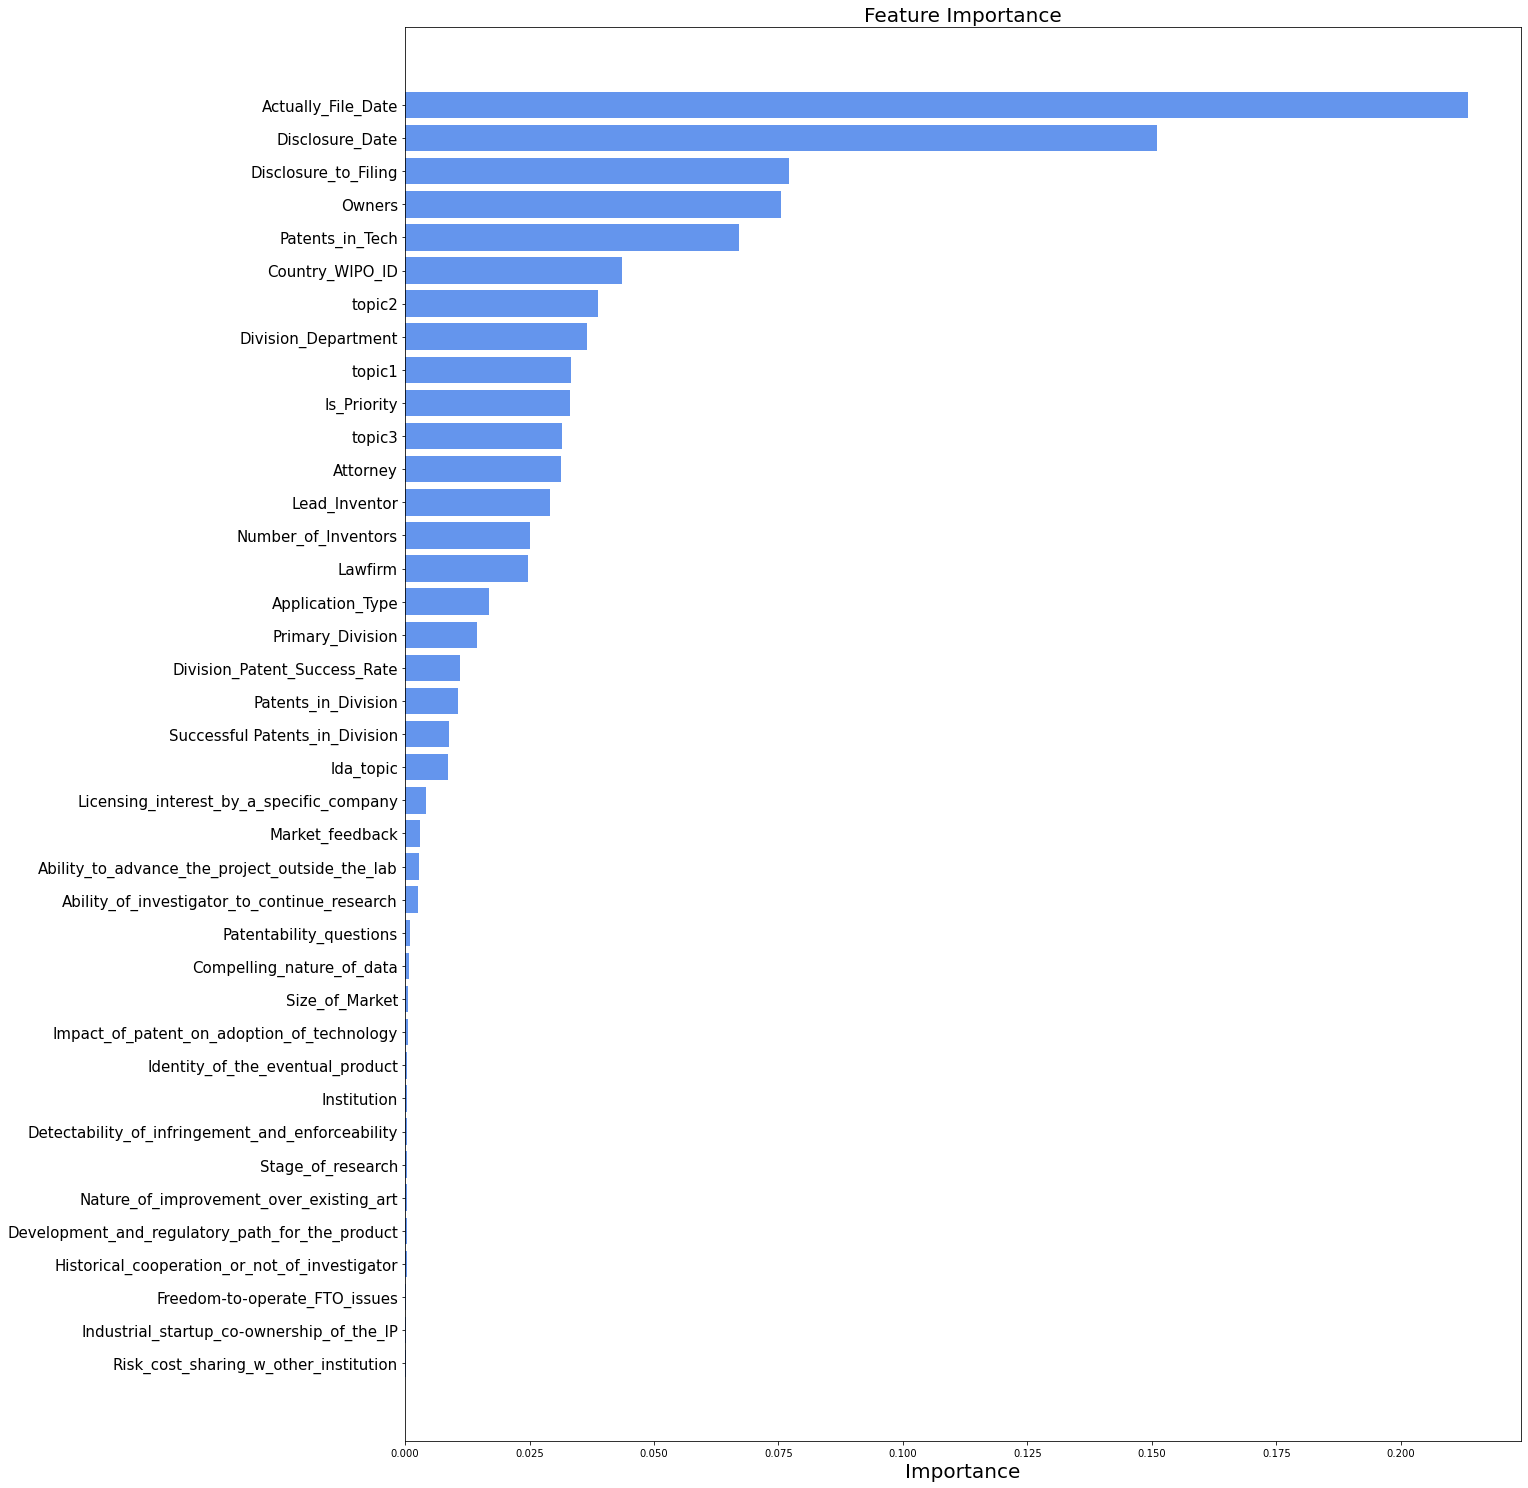

In [93]:
# Review feature importance in descending order
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 26))
plt.title('Feature Importance', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='cornflowerblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=15)
plt.xlabel('Importance', fontsize=20)
plt.show()

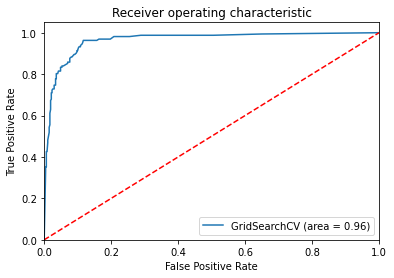

In [94]:
roc_curve(rfc)

### 4.2. Bagging Classification

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


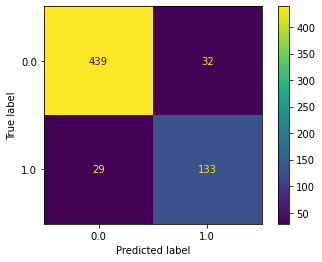


Bagging Classification Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.94      0.93      0.94       471
         1.0       0.81      0.82      0.81       162

    accuracy                           0.90       633
   macro avg       0.87      0.88      0.87       633
weighted avg       0.90      0.90      0.90       633


Accuracy: 0.904

 Bagging Classification Train/Test/CV Scoring


,train,test,cv
recall,0.98,0.877,0.929
precision,0.98,0.872,0.936
f1,0.98,0.874,0.932


In [101]:
#Produce and save the model, then load and apply the model.
bag = BaggingClassifier(DecisionTreeClassifier(),max_samples=0.5,max_features=1.0,n_estimators=10, random_state=42)
bag.fit(x_train, y_train)
bag_predictions = bag.predict(x_test)
bag_predictions_train=bag.predict(x_train)

bag_matrix = metrics.confusion_matrix(y_test,bag_predictions)

plot_confusion_matrix(bag, x_test, y_test)  
plt.show()

class_report_bag = classification_report(y_test, bag_predictions)
print("\nBagging Classification Confusion Matrix\n",class_report_bag)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,bag_predictions),3))

print('\n Bagging Classification Train/Test/CV Scoring')
fitting_score(bag_predictions_train, bag_predictions, bag)

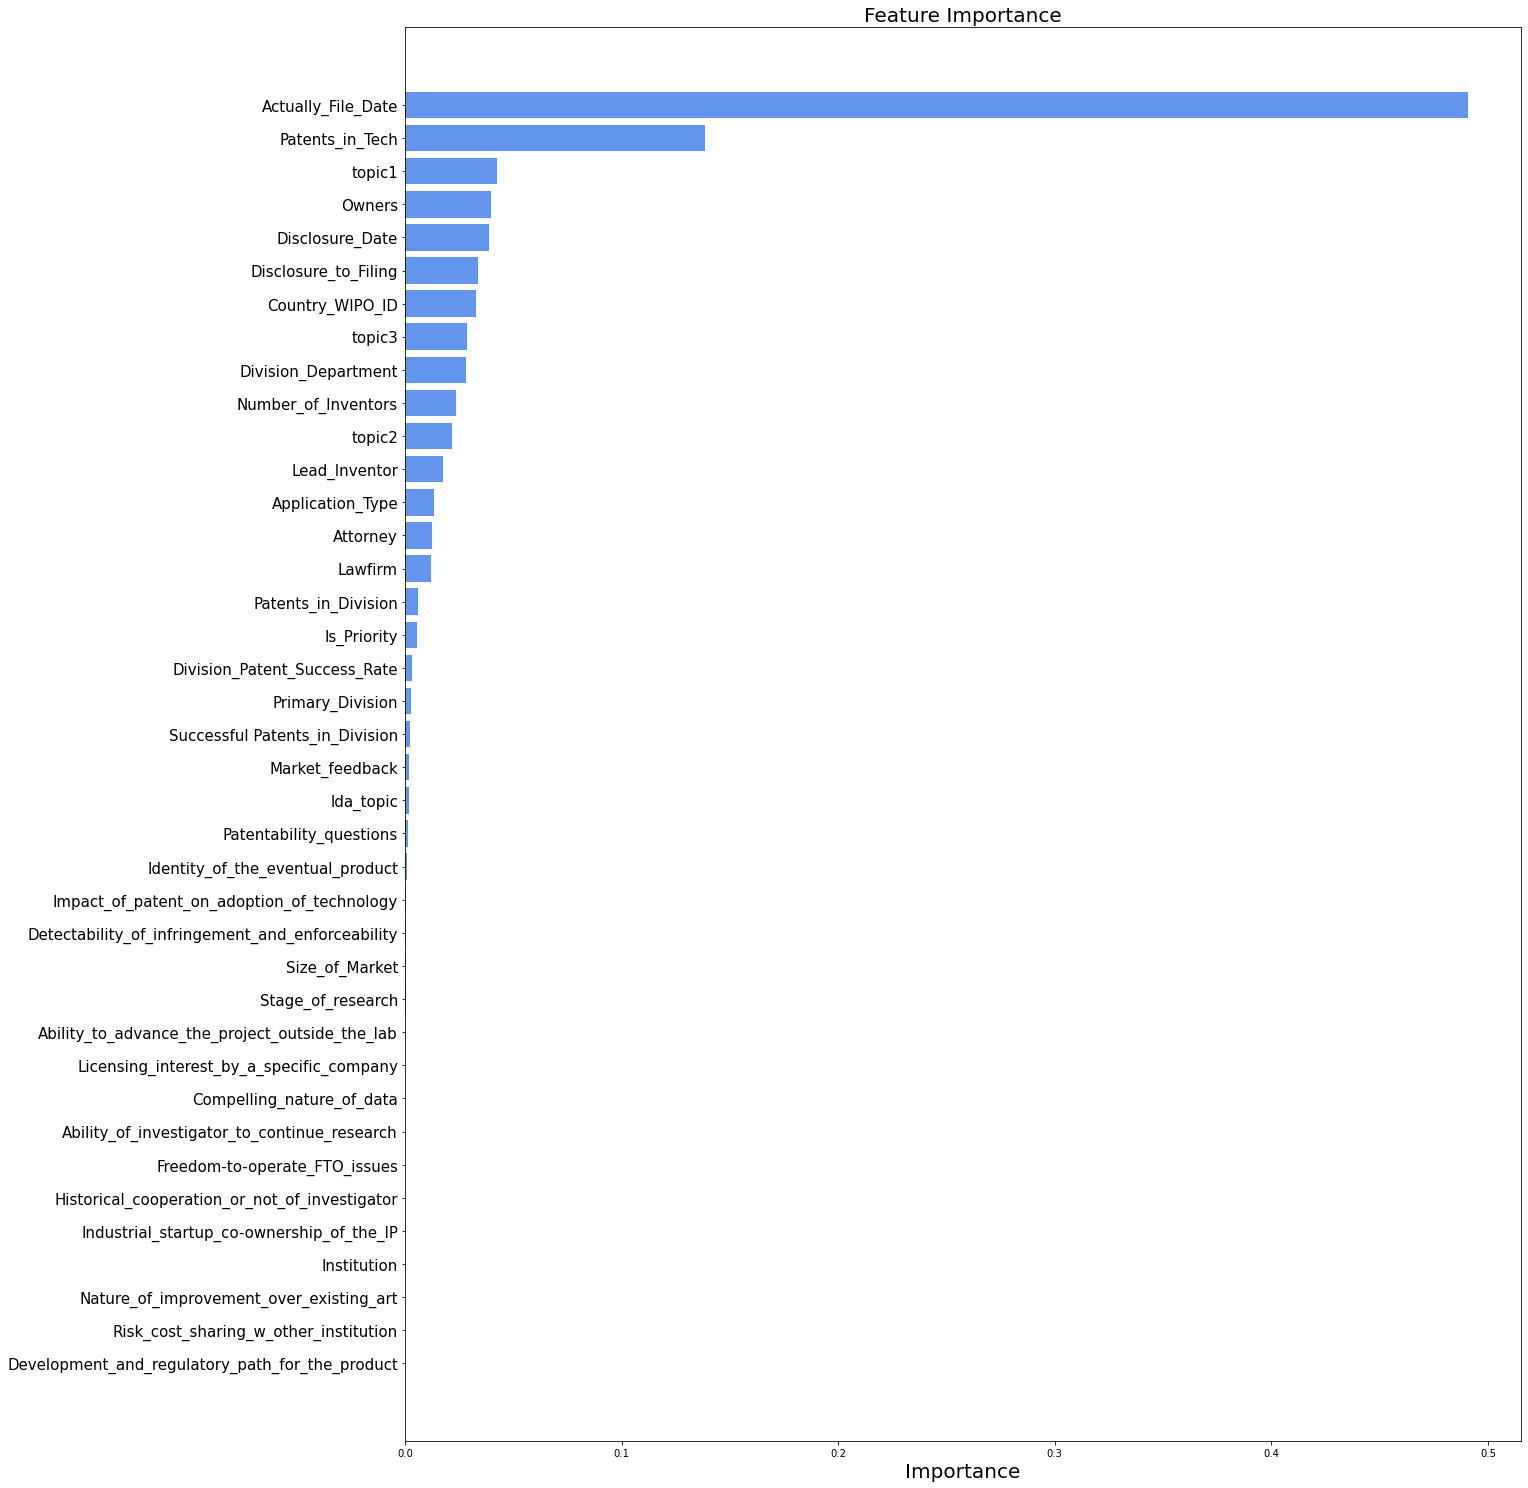

In [102]:
# Review feature importance in descending order
features = X.columns
feature_importances = np.mean([
    tree.feature_importances_ for tree in bag.estimators_
], axis=0)

indices = np.argsort(feature_importances)

plt.figure(figsize=(20, 26))
plt.title('Feature Importance', fontsize=20)
plt.barh(range(len(indices)), feature_importances[indices], color='cornflowerblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize=15)
plt.xlabel('Importance', fontsize=20)
plt.show()

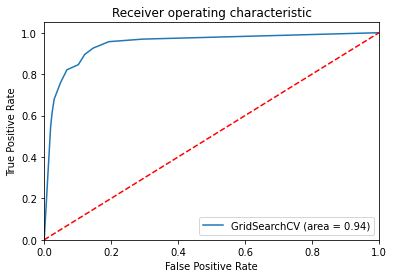

In [103]:
roc_curve(bag)

### 4.3. Gradient Boosting 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


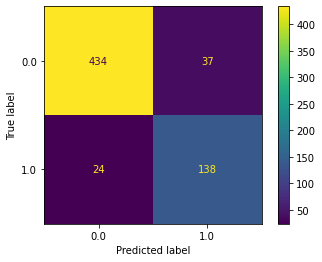


Gradient Boosting Classifier Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.93       471
         1.0       0.79      0.85      0.82       162

    accuracy                           0.90       633
   macro avg       0.87      0.89      0.88       633
weighted avg       0.91      0.90      0.90       633


Accuracy: 0.904

 Gradient Boosting Classification Train/Test/CV Scoring


,train,test,cv
recall,0.954,0.887,0.940
precision,0.955,0.868,0.917
f1,0.954,0.877,0.928


In [105]:
#Produce and save the model, then load and apply the model.
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(x_train, y_train)
gbm_predictions = gbm.predict(x_test)
gbm_predictions_train = gbm.predict(x_train)

gbm_matrix = metrics.confusion_matrix(y_test,gbm_predictions)

plot_confusion_matrix(gbm, x_test, y_test)  
plt.show()

class_report_gbm = classification_report(y_test, gbm_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",class_report_gbm)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,gbm_predictions),3))

print('\n Gradient Boosting Classification Train/Test/CV Scoring')
fitting_score(gbm_predictions_train, gbm_predictions, gbm)

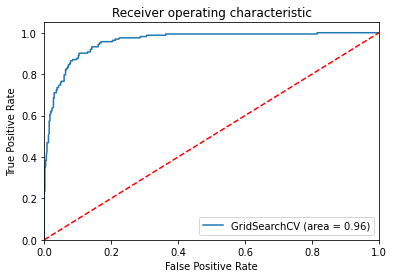

In [106]:
roc_curve(gbm)

### 4.4. Decision Tree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


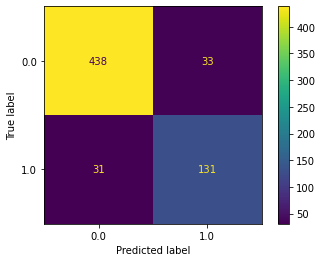


Decision Tree Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       471
         1.0       0.80      0.81      0.80       162

    accuracy                           0.90       633
   macro avg       0.87      0.87      0.87       633
weighted avg       0.90      0.90      0.90       633


Accuracy: 0.899

 Decision Tree Train/Test/CV Scoring


,train,test,cv
recall,1.0,0.869,0.923
precision,1.0,0.866,0.924
f1,1.0,0.868,0.923


In [108]:
#Produce and save the model, then load and apply the model.
dt = DecisionTreeClassifier(random_state=42)
dt.fit(x_train, y_train)
dt_predictions = dt.predict(x_test)
dt_predictions_train = dt.predict(x_train)

dt_matrix = metrics.confusion_matrix(y_test,dt_predictions)

plot_confusion_matrix(dt, x_test, y_test)  
plt.show()

class_report_dt = classification_report(y_test, dt_predictions)
print("\nDecision Tree Confusion Matrix\n",class_report_dt)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,dt_predictions),3))

print('\n Decision Tree Train/Test/CV Scoring')
fitting_score(dt_predictions_train, dt_predictions, dt)

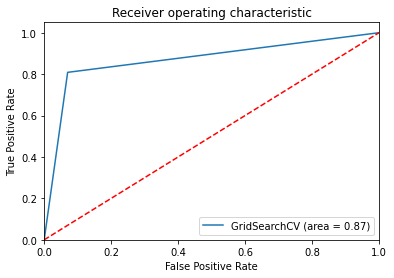

In [109]:
roc_curve(dt)

### 4.5. KNN

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


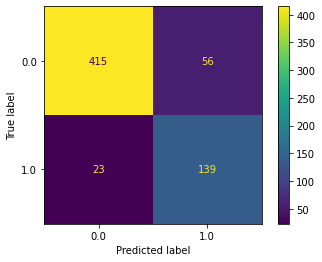


KNN Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.95      0.88      0.91       471
         1.0       0.71      0.86      0.78       162

    accuracy                           0.88       633
   macro avg       0.83      0.87      0.85       633
weighted avg       0.89      0.88      0.88       633


Accuracy: 0.875

 Decision Tree Train/Test/CV Scoring


,train,test,cv
recall,0.944,0.870,0.963
precision,0.946,0.830,0.872
f1,0.943,0.846,0.915


In [116]:
#Produce and save the model, then load and apply the model.
knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
knn.fit(x_train, y_train)
knn_predictions = knn.predict(x_test)
knn_predictions_train = knn.predict(x_train)

knn_matrix = metrics.confusion_matrix(y_test,knn_predictions)

plot_confusion_matrix(knn, x_test, y_test)  
plt.show()

class_report_knn = classification_report(y_test, knn_predictions)
print("\nKNN Confusion Matrix\n",class_report_knn)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,knn_predictions),3))

print('\n Decision Tree Train/Test/CV Scoring')
fitting_score(knn_predictions_train, knn_predictions, knn)

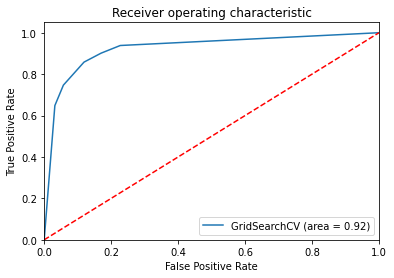

In [117]:
roc_curve(knn)

### 4.6 XGBoost 

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


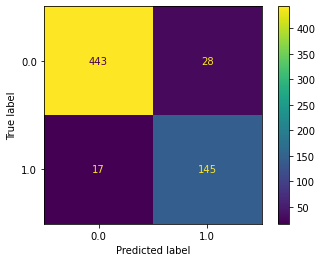


Gradient Boosting Classifier Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       471
         1.0       0.84      0.90      0.87       162

    accuracy                           0.93       633
   macro avg       0.90      0.92      0.91       633
weighted avg       0.93      0.93      0.93       633


Accuracy: 0.929

 Gradient Boosting Classification Train/Test/CV Scoring


,train,test,cv
recall,0.955,0.918,0.943
precision,0.955,0.901,0.912
f1,0.955,0.909,0.927


In [172]:
#Produce and save the model, then load and apply the model.
# Initial estimations for XGBoost were included within the model 
xgb = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='error', gamma=10,
                   colsample_bytree=0.25, learning_rate=0.1, n_estimators=200, reg_lambda=1)
xgb.fit(x_train, y_train)
xgb_predictions = xgb.predict(x_test)
xgb_predictions_train = xgb.predict(x_train)

xgb_matrix = metrics.confusion_matrix(y_test,xgb_predictions)

plot_confusion_matrix(xgb, x_test, y_test)  
plt.show()

class_report_xgb = classification_report(y_test, xgb_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",class_report_xgb)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,xgb_predictions),3))

print('\n Gradient Boosting Classification Train/Test/CV Scoring')
fitting_score(xgb_predictions_train, xgb_predictions, xgb)

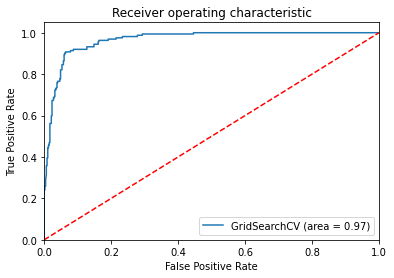

In [175]:
roc_curve(xgb)

## 5. Hyperparameter Tuning

### 5.1. Parameter Tuning for Gradient Boosting (Good f1 scoring and less overfitting)

In [57]:
# Tune learning rate and n_estimators
tuned_param = {'learning_rate':[0.1,0.05,0.01], 'n_estimators':[100,250,500], 'min_samples_split':[2,20,50], 
               'min_samples_leaf':[1, 10, 20]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, random_state=2, 
                               subsample=1), 
                      param_grid = tuned_param, scoring='f1',n_jobs=4, cv=5)
tuning.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4, random_state=2,
                                                  subsample=1),
             n_jobs=4,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'min_samples_leaf': [1, 10, 20],
                         'min_samples_split': [2, 20, 50],
                         'n_estimators': [100, 250, 500]},
             scoring='f1')

In [58]:
tuning.best_params_, (-tuning.best_score_)**(1/2)

<ipython-input-58-efad291d2317>:1: RuntimeWarning: invalid value encountered in double_scalars
  tuning.best_params_, (-tuning.best_score_)**(1/2)


({'learning_rate': 0.1,
  'min_samples_leaf': 20,
  'min_samples_split': 2,
  'n_estimators': 250},
 nan)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


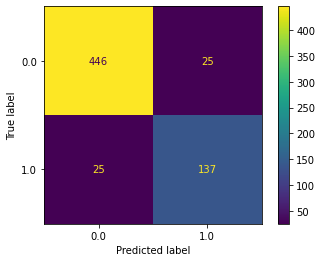


Gradient Boosting Classifier Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       471
         1.0       0.85      0.85      0.85       162

    accuracy                           0.92       633
   macro avg       0.90      0.90      0.90       633
weighted avg       0.92      0.92      0.92       633


Accuracy: 0.921

 Gradient Boosting Classifier Train/Test/CV Scoring


,train,test,cv
recall,0.954,0.896,0.948
precision,0.955,0.896,0.951
f1,0.954,0.896,0.949


In [118]:
#Produce and save the model, then load and apply the model.
gbm = GradientBoostingClassifier(max_depth=4, random_state=42, 
                               subsample=1, learning_rate= 0.1, min_samples_leaf=20,
                                min_samples_split=2, n_estimators=250)
gbm.fit(x_train, y_train)
gbm_predictions = gbm.predict(x_test)

gbm_matrix = metrics.confusion_matrix(y_test,gbm_predictions)

plot_confusion_matrix(gbm, x_test, y_test)  
plt.show()

class_report_gbm = classification_report(y_test, gbm_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",class_report_gbm)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,gbm_predictions),3))

print('\n Gradient Boosting Classifier Train/Test/CV Scoring')
fitting_score(gbm_predictions_train, gbm_predictions, gbm)

### 5.2. Parameter Tuning for Random Forest (best f1 test scoring, but overfitting occurring)

In [76]:
# Tune learning rate and n_estimators
tuned_param = {'n_estimators':[100, 300, 500, 800, 1200], 'min_samples_split':[2, 5, 10, 15, 100], 
               'min_samples_leaf':[1, 2, 5, 10], 'max_depth':[5, 8, 15, 25, 30]}
tuning = GridSearchCV(estimator =rfc, 
                      param_grid = tuned_param, scoring='f1',n_jobs=4, cv=3, verbose = 1)
tuning.fit(x_train,y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_depth=80, min_samples_split=5,
                                              n_estimators=1000),
             n_jobs=4,
             param_grid={'max_depth': [5, 8, 15, 25, 30],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 15, 100],
                         'n_estimators': [100, 300, 500, 800, 1200]},
             scoring='f1', verbose=1)

In [77]:
tuning.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


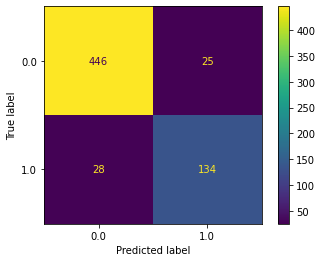


Random Forest Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       471
         1.0       0.84      0.83      0.83       162

    accuracy                           0.92       633
   macro avg       0.89      0.89      0.89       633
weighted avg       0.92      0.92      0.92       633


Accuracy: 0.916

 Random Forest Train/Test/CV Scoring


,train,test,cv
recall,0.999,0.887,0.948
precision,0.999,0.892,0.940
f1,0.999,0.889,0.943


In [174]:
#Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(max_depth=200, min_samples_leaf=1,
                            min_samples_split=2, n_estimators=500, random_state=42)
rfc.fit(x_train, y_train)
rfc_predictions = rfc.predict(x_test)
rfc_predictions_train=rfc.predict(x_train)

rfc_matrix = metrics.confusion_matrix(y_test,rfc_predictions)

plot_confusion_matrix(rfc, x_test, y_test)  
plt.show()

class_report_rfc = classification_report(y_test, rfc_predictions)
print("\nRandom Forest Confusion Matrix\n",class_report_rfc)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,rfc_predictions),3))


print('\n Random Forest Train/Test/CV Scoring')
fitting_score(rfc_predictions_train, rfc_predictions, rfc)

### 5.3 Parameter Tuning for XGBoost 

In [176]:
param_grid = {
    "max_depth": [5, 7, 10, 15],
    "learning_rate": [0.1, 0.01, 0.05],
    "gamma": [5, 10, 20, 30],
    "reg_lambda": [1, 5, 10],
    "reg_alpha": [1, 5, 10, 20],
    "scale_pos_weight": [2, 3, 5, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.25, 0.35, 0.45],
    'min_child_weight': [0,1]
}

tuning = GridSearchCV(estimator =XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='error'), 
                      param_grid = param_grid, n_jobs=-1, cv=3, scoring="f1")
tuning.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='error', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monoto...
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             n_job

In [177]:
tuning.best_params_

{'colsample_bytree': 0.35,
 'gamma': 5,
 'learning_rate': 0.1,
 'max_depth': 15,
 'min_child_weight': 0,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 2,
 'subsample': 0.9}

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


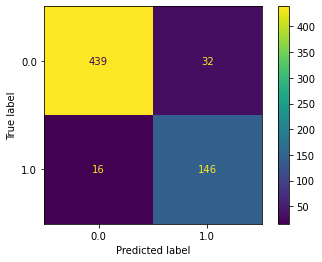


Gradient Boosting Classifier Confusion Matrix
               precision    recall  f1-score   support

         0.0       0.96      0.93      0.95       471
         1.0       0.82      0.90      0.86       162

    accuracy                           0.92       633
   macro avg       0.89      0.92      0.90       633
weighted avg       0.93      0.92      0.93       633


Accuracy: 0.924

 Gradient Boosting Classification Train/Test/CV Scoring


,train,test,cv
recall,0.972,0.917,0.967
precision,0.973,0.893,0.915
f1,0.972,0.903,0.939


In [183]:
xgb = XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='error', gamma=5,
                   colsample_bytree=0.35, learning_rate=0.1, n_estimators=200, reg_lambda=1, max_depth=15,
                   min_child_weight=0, reg_alpha=1, scale_pos_weight=2, subsample=0.9)

xgb.fit(x_train, y_train)
xgb_predictions = xgb.predict(x_test)
xgb_predictions_train = xgb.predict(x_train)

xgb_matrix = metrics.confusion_matrix(y_test,xgb_predictions)

plot_confusion_matrix(xgb, x_test, y_test)  
plt.show()

class_report_xgb = classification_report(y_test, xgb_predictions)
print("\nGradient Boosting Classifier Confusion Matrix\n",class_report_xgb)

print("\nAccuracy:",round(metrics.accuracy_score(y_test,xgb_predictions),3))

print('\n Gradient Boosting Classification Train/Test/CV Scoring')
fitting_score(xgb_predictions_train, xgb_predictions, xgb)

# XX provides the best overall accuracy. XX yields the best recall. Discuss trade-offs with Polsky Center 

### One slide: "Cost of incorrect prediction". What is more expensive: no-fund that should be funded, or funded that should not have been. (Type I or Type II more impactful). Can we get a sense of incorrect prediction from client? Ask Polsky best way to calculate average cost per patent and average licensing revenue per successful patent 

### Second slide: Once understood, use the metric from slide 1 to compare models. Overfitting check (look at generalizability of the model). Look at train error, test error, CV error to get justification to convince judge the model is not overfitting and is generalizable 

### Third slide: Interperetability of features. What impact does each feature have on the target variable. Run feature importance, shapely values (https://towardsdatascience.com/shap-for-feature-selection-and-hyperparameter-tuning-a330ec0ea104) to see which features to designate. Which features can Polsky change that would convert something from no-fund to fund (this will be determined by coefficient effect of statistically significant features). 

### Run statistical analysis on each features. Recommend to client what input variables can be adjusted. GLM logistic regression using logit and probit to test significance (http://web.pdx.edu/~newsomj/cdaclass/ho_glm.pdf)

### Run statistical analysis on each features. GLM logistic regression using logit and probit to test significance

In [41]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(x_train,y_train)
logreg

print("Training set score: {:.3f}".format(logreg.score(x_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(x_test,y_test)))

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary())

Training set score: 0.860
Test set score: 0.818


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


         Current function value: 0.913878
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:          Patent_Status   No. Observations:                 3165
Model:                          Logit   Df Residuals:                     3126
Method:                           MLE   Df Model:                           38
Date:                Thu, 21 Jul 2022   Pseudo R-squ.:                 -0.6087
Time:                        10:13:02   Log-Likelihood:                -2892.4
converged:                      False   LL-Null:                       -1798.0
Covariance Type:            nonrobust   LLR p-value:                     1.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Disclosure_Date                                   -2.43e+05   1.57e+

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
# get odds ratio
# np.exp(result.params)